### Benchmarking "Allosteric Regulation of the P2X4 Recepter Channel Pore Dilation"

Zemkova, Khadra, Rokic, Tvrdonova, Sherman, and Stojikovic

1. Cell type: HEK293T
2. rP2X4
3. 13-state model

In [3]:
# Required Packages
## Function for integreating ODE and displaying results
import scipy.integrate
from scipy.integrate import odeint
import numpy as np
import matplotlib.pylab as plt
import math
from scipy.interpolate import spline
import pickle as pk
%matplotlib inline

In [7]:
def ft(y,t,A,IVM):
    D1, D2, D3, D4, C1, C2, C3, C4, Q1, Q2, Q3, Q4, N = y
    
    k = np.array([0.4, 8000000, 0.5, 500000, 0.6, 400000]) # k1[1/s],k2[1/(M*s)],k3[1/s],k4[1/(M*s)],k5[1/s],k6[1/(M*s)]
    L = np.array([0.01, 0.04, 0.5])                       # L1[1/s], L2[1/s], L3[1/s]
    H = np.array([0.013, 0.35, 1.4, 0.001])               # H1[1/s], H2[1/s], H3[1/s], H4[1/s]
    al = 100 # unitless
    be = 1.4e-6 # [M]
    KIVM = IVM/(be + IVM)
    G = 1 + al*KIVM
    F = 1 - KIVM
    
    dD1dt = k[0]*D2 - (3*k[1]*A + H[0])*D1
    dD2dt = 3*k[1]*A*D1 + 2*k[2]*D3 + H[1]*C2 - (k[0] + 2*k[3]*A)*D2
    dD3dt = 2*k[3]*A*D2 + 3*k[4]*D4 + H[1]*Q1 - (2*k[2] + k[5]*A)*D3
    dD4dt = k[5]*A*D3 + H[1]*Q2 - (3*k[4] + H[2])*D4
    
    dC1dt = H[0]*D1 + k[0]*G*C2 + L[0]*C4 + H[3]*N - 3*k[1]*A*F*C1
    dC2dt = 3*k[1]*A*F*C1 + 2*k[2]*G*Q1 - (k[0]*G + 2*k[3]*A*F + H[1])*C2
    dC3dt = 3*k[1]*A*F*C4 + 2*k[0]*G*Q4 - (k[0]*G + 2*k[1]*A*F)*C3
    dC4dt = k[0]*G*C3 - (L[0] + 3*k[1]*A*F)*C4
    
    dQ1dt = 2*k[3]*A*F*C2 + 3*k[4]*G*Q2 - (2*k[2]*G + k[5]*A*F + H[1])*Q1
    dQ2dt = k[5]*A*F*Q1 + L[1]*Q3 - (3*k[4]*G + L[2]*(1-G) + H[1])*Q2
    dQ3dt = k[1]*A*F*Q4 + L[2]*(1-G)*Q2 - (3*k[0]*G + L[1])*Q3
    dQ4dt = 2*k[1]*A*F*C3 + 3*k[0]*G*Q3 - (2*k[0]*G + k[1]*A*F)*Q4
    
    dNdt = H[2]*D4 - H[3]*N
    
    dydt = [dD1dt, dD2dt, dD3dt, dD4dt, dC1dt, dC2dt, dC3dt, dC4dt, dQ1dt, dQ2dt, dQ3dt, dQ4dt, dNdt]
    
    return dydt 

In [11]:
def Ip2x4(st, du, step, interval, ATP, IVM):
    # Input info.
    ## st : stimulation time -> 2 seconds
    ## du : total duration in 0.5 minutes -> 2 [du] = 1 min
    ## ATP : ATP concentration in uM
    ## IVM : IVM concentration in uM -> will be set to zero
    ## interval : the time interval between stimulation (end to begin)
    ## step : a number of steps between seconds
    
    iters = np.arange(du)
    Ivm = IVM*10**-6  # IVM concentration in [M]
    # Empty Shell for each state
    D1 = []
    D2 = []
    D3 = []
    D4 = []
    C1 = []
    C2 = []
    C3 = []
    C4 = []
    Q1 = []
    Q2 = []
    Q3 = []
    Q4 = []
    N = []
    time = [] 
    
    for i in iters:
        
        ti = i*interval          # 0, 30, 60, 90 .... 
        tf = (i+1)*interval-st   # 28, 58, 88, 118 ....
        
        trs = scipy.linspace(ti,tf,(interval*step+1))  # time without ATP stimulation
        tst = scipy.linspace(tf,(tf+st),(st*step+1))  # time with ATP stimulation
        
        
        if i == 0 : # Very first step of calculation
            A = 0   # Turn off the ATP concentration
            y0 = np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]) # Very first step
        else :            
            y0 = np.array([D1[-1],D2[-1],D3[-1],D4[-1],C1[-1],C2[-1],C3[-1],C4[-1],Q1[-1],Q2[-1],Q3[-1],Q4[-1],N[-1]]) 
        
        ## Solving equation during the resting state
        A = 0  # ATP concentration in [M] -> off
        yrs = scipy.integrate.odeint(ft,y0,trs,args=(A,IVM,))
        ### Storing data from the resting state
        D1 = np.append(D1,yrs[:,0])
        D2 = np.append(D2,yrs[:,1])
        D3 = np.append(D3,yrs[:,2])
        D4 = np.append(D4,yrs[:,3])
        C1 = np.append(C1,yrs[:,4])
        C2 = np.append(C2,yrs[:,5])
        C3 = np.append(C3,yrs[:,6])
        C4 = np.append(C4,yrs[:,7])        
        Q1 = np.append(Q1,yrs[:,8])
        Q2 = np.append(Q2,yrs[:,9])
        Q3 = np.append(Q3,yrs[:,10])
        Q4 = np.append(Q4,yrs[:,11])
        N = np.append(N,yrs[:,12])
        time = np.append(time,trs)
        
        ## Solving equation during the stimulation
        ### Updating the new initial values 
        A = ATP*(10**-6)  # ATP concentration in [M] -> on
        y1 = np.array([D1[-1],D2[-1],D3[-1],D4[-1],C1[-1],C2[-1],C3[-1],C4[-1],Q1[-1],Q2[-1],Q3[-1],Q4[-1],N[-1]])
        yst = scipy.integrate.odeint(ft,y1,tst,args=(A,IVM,))
        ### Storing data from the stimulation                 
        D1 = np.append(D1,yst[:,0])
        D2 = np.append(D2,yst[:,1])
        D3 = np.append(D3,yst[:,2])
        D4 = np.append(D4,yst[:,3])
        C1 = np.append(C1,yst[:,4])
        C2 = np.append(C2,yst[:,5])
        C3 = np.append(C3,yst[:,6])
        C4 = np.append(C4,yst[:,7])        
        Q1 = np.append(Q1,yst[:,8])
        Q2 = np.append(Q2,yst[:,9])
        Q3 = np.append(Q3,yst[:,10])
        Q4 = np.append(Q4,yst[:,11])
        N = np.append(N,yst[:,12])                             
        time = np.append(time,tst)
        
        ## Removing variables for memory efficiency
        y0 = None
        y1 = None
        tst = None
        trs = None                                              
    
    # Current conversion
    g12 = 3e-8  # [S]
    g34 = 8e-8  # [S]
    V = -0.06   # [V]
    E12 = 0     # [V]
    E34 = 0     # [V]
    
    I1 = (g12*(Q1 + Q2)*(V - E12) + g34*(Q3 + Q4)*(V - E34))*10**9 # in [nA]
    
    results = np.array([time,I1])
    
    pk.dump(results,open("pythonp2x4.p","wb"))
    
    # Khadra P2X4 HEK ATP st 63s 100 uM 1st pulse
    t16 = np.array([0,0.75,6,11.25,18.75,30.75,75])+190
    # Khadra P2X4 HEK ATP st 63s 100 uM 2nd pulse
    t17 = np.array([0,1.2,3.3,6.3,8.7,33,63])+430
    # Toulme P2X4 MG ATP st 30s 100 uM
    t18 = np.array([0,0.2040816327,1.734693878,4.693877551,8.571428571,13.7755102,24.08163265,34.69387755])+190
    t19 = np.array([0,0.2040816327,1.734693878,4.693877551,8.571428571,13.7755102,24.08163265,34.69387755])+430

    y16 = np.array([0,-2.337552743,-0.7257383966,-0.3037974684,-0.1434599156,-0.08438818565,-0.01687763713])
    y17 = np.array([0,-0.5518987342,-0.1181434599,-0.04556962025,-0.01687763713,-0.01687763713,0.005063291139])
    y18 = 0.001*np.array([0,-366.8965517,-270.3448276,-171.0344828,-107.5862069,-57.93103448,-22.06896552,2.75862069])
    y19 = 0.001*np.array([0,-366.8965517,-270.3448276,-171.0344828,-107.5862069,-57.93103448,-22.06896552,2.75862069])

    ATPkha = np.array([0.08,0.08,0.08,0.08,0.08,0.08,0.08])+0.05
    ATPtou = np.array([0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.09])
    tmodel1 = np.array([0,50])+190
    tmodel2 = np.array([0,50])+430
    ATPmodel = np.array([0.17,0.17])
    plt.figure(figsize=(7,7))
    plt.tick_params(labelsize=12)
    
    plt.plot(time,I1,'k--',lw = 3,label="Model")
    plt.plot(tmodel1,ATPmodel,'black',lw=5,label="ATP-Model")
    plt.plot(tmodel2,ATPmodel,'black',lw=5)
    plt.plot(t16,y16,'r-x',alpha=0.5,label="Zemkova-rP2X4-HEK")
    plt.plot(t17,y17,'r-x',alpha=0.5)
    plt.plot(t16,ATPkha,'red',lw=5,alpha=1,label="ATP-Zemkova")
    plt.plot(t17,ATPkha,'red',lw=5,alpha=1)
    plt.plot(t18,y18,'b-o',alpha=0.3,ms=10,label="Toulme-rP2X4-MG")
    plt.plot(t19,y19,'b-o',alpha=0.3,ms=10)
    plt.plot(t18,ATPtou,'blue',lw=5,alpha=1,label="ATP-Toulme")
    plt.plot(t19,ATPtou,'blue',lw=5,alpha=1)
    plt.xlabel("time (s)",fontsize=15)
    plt.ylabel("current (nA)",fontsize=15)
    plt.legend(loc=0,fontsize=12) 
    plt.ylim((-2.5,0.2))
    plt.savefig("p2x4vali.png")
    
    results = [time, I1]
    
    return results

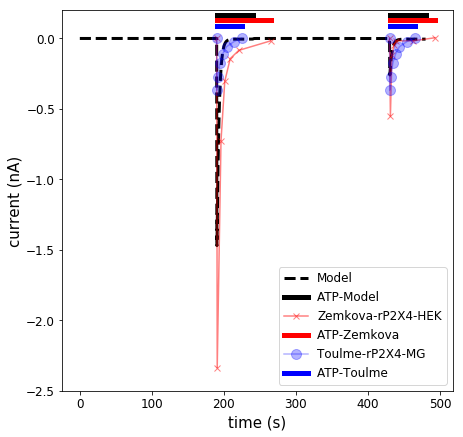

In [12]:
results = Ip2x4(50, 2, 1000, 240, 10, 0) #st, du, step, interval, ATP, IVM

In [19]:
time, Imodel = results
t16 = np.array([0,0.75,6,11.25,18.75,30.75,75])+190
y16 = np.array([0,-2.337552743,-0.7257383966,-0.3037974684,-0.1434599156,-0.08438818565,-0.01687763713])
lit = [t16, y16]

In [20]:
def test(lit_data,model_data): # indpnt = independent variable, dpnt = dependent variable
    lit_xset, lit_yset = lit_data    # literature data
    model_xset, model_yset = model_data  # modelled data

    est_yset = np.interp(lit_xset,model_xset,model_yset)

    N = np.shape(est_yset)[0]
    iters = np.arange(N)

    err2 = 0
    
    for i in iters:
        print(lit_yset[i], est_yset[i])
        err2 = err2 + (lit_yset[i] - est_yset[i])**2

    return err2

In [21]:
error = test(lit,results)
print(error)

0.0 -0.0
-2.337552743 -1.3383832934
-0.7257383966 -0.216453111157
-0.3037974684 -0.0381942114749
-0.1434599156 -0.00717700621154
-0.08438818565 -0.00482231597572
-0.01687763713 -1.25494566678e-11
1.35344479471
